In [1]:
from mobilenet_pytorch import MobileNetV1
import torch
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import IPython.display
import pickle
import requests

from utils import *

CLASSIFIER_PATH = './models/classifier.pth'

## Load pretrained models:
We load the pretrained pytorch models after transferring their tensorflow models 

In [2]:
classifier = MobileNetV1()
classifier.load_state_dict(torch.load(CLASSIFIER_PATH))
classifier.eval()

generator = tf.keras.models.load_model('./generator.savedmodel')
discriminator = tf.keras.models.load_model('./discriminator.savedmodel')

In [3]:
#Global variables

num_layers = 14
label_size = 2
resolution = 256

## Latents extraction: 
We don't provide the dataset_provider, so we will load the dlatents from a precomputed np.array.
Here we present how to run the encoder on one image, to calculate one dlatent (we pre-calculate for 250)

In [4]:
#@title Load the precomputed dlatents (already concatenated to the labels)
latents_file = open("./saved_dlantents.pkl",'rb')
dlatents = pickle.load(latents_file)

In [5]:
#@title Load effect data from the tfrecord {form-width: '20%'}
data_path = './data/examples_1.tfrecord'
num_classes = 2
print(f'Loaded dataset: {data_path}')
table = tf.data.TFRecordDataset([data_path])
# Read sspace tfrecord unwrapped:
style_change_effect = []
dlatents = []
base_probs = []
for raw_record in table:
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  dlatents.append(
      np.array(example.features.feature['dlatent'].float_list.value))
  seffect = np.array(
      example.features.feature['result'].float_list.value).reshape(
          (-1, 2, num_classes))
  style_change_effect.append(seffect.transpose([1, 0, 2]))
  base_probs.append(
      np.array(example.features.feature['base_prob'].float_list.value))

style_change_effect = np.array(style_change_effect)
dlatents = np.array(dlatents)
W_values, style_change_effect, base_probs = dlatents, style_change_effect, np.array(base_probs)

style_change_effect = filter_unstable_images(style_change_effect, effect_threshold=2)

all_style_vectors = tf.concat(generator.style_vector_calculator(W_values, training=False)[0], axis=1).numpy()
style_min = np.min(all_style_vectors, axis=0)
style_max = np.max(all_style_vectors, axis=0)

all_style_vectors_distances = np.zeros((all_style_vectors.shape[0], all_style_vectors.shape[1], 2))
all_style_vectors_distances[:,:, 0] = all_style_vectors - np.tile(style_min, (all_style_vectors.shape[0], 1))
all_style_vectors_distances[:,:, 1] = np.tile(style_max, (all_style_vectors.shape[0], 1)) - all_style_vectors

Loaded dataset: ./data/examples_1.tfrecord


## Run the extraction step of AttFind

In [6]:
#@title Split by class
all_labels = np.argmax(base_probs, axis=1)
style_effect_classes = {}
W_classes = {}
style_vectors_distances_classes = {}
all_style_vectors_classes = {}
for img_ind in range(label_size):
  img_inx = np.array([i for i in range(all_labels.shape[0]) 
  if all_labels[i] == img_ind])
  curr_style_effect = np.zeros((len(img_inx), style_change_effect.shape[1], 
                                style_change_effect.shape[2], style_change_effect.shape[3]))
  curr_w = np.zeros((len(img_inx), W_values.shape[1]))
  curr_style_vector_distances = np.zeros((len(img_inx), style_change_effect.shape[2], 2))
  for k, i in enumerate(img_inx):
    curr_style_effect[k, :, :] = style_change_effect[i, :, :, :]
    curr_w[k, :] = W_values[i, :]
    curr_style_vector_distances[k, :, :] = all_style_vectors_distances[i, :, :]
  style_effect_classes[img_ind] = curr_style_effect
  W_classes[img_ind] = curr_w
  style_vectors_distances_classes[img_ind] = curr_style_vector_distances
  all_style_vectors_classes[img_ind] = all_style_vectors[img_inx]
  print(f'Class {img_ind}, {len(img_inx)} images.')

Class 0, 90 images.
Class 1, 160 images.


In [7]:
#@title Significant S values - combined {form-width: '20%'}
label_size_clasifier = 2 #@param
num_indices =  8 #@param
effect_threshold = 0.2 #@param
use_discriminator = False #@param {type: 'boolean'}
discriminator_model = discriminator if use_discriminator else None
s_indices_and_signs_dict = {}

for class_index in [0, 1]:
  split_ind = 1 - class_index
  all_s = style_effect_classes[split_ind]
  all_w = W_classes[split_ind]

  # Find s indicies
  s_indices_and_signs = find_significant_styles(
    style_change_effect=all_s,
    num_indices=num_indices,
    class_index=class_index,
    discriminator=discriminator_model,
    generator=generator,
    classifier=classifier,
    all_dlatents=all_w,
    style_min=style_min,
    style_max=style_max,
    max_image_effect=effect_threshold*5,
    label_size=label_size_clasifier,
    discriminator_threshold=0.2,
    sindex_offset=0)

  s_indices_and_signs_dict[class_index] = s_indices_and_signs

# Combine the style indicies for the two classes.
sindex_class_0 = [sindex for _, sindex in s_indices_and_signs_dict[0]]

all_sindex_joined_class_0 = [(1 - direction, sindex) for direction, sindex in 
                             s_indices_and_signs_dict[1] if sindex not in sindex_class_0]
all_sindex_joined_class_0 += s_indices_and_signs_dict[0]

scores = []
for direction, sindex in all_sindex_joined_class_0:
  other_direction = 1 if direction == 0 else 0
  curr_score = np.mean(style_change_effect[:, direction, sindex, 0]) + np.mean(style_change_effect[:, other_direction, sindex, 1])
  scores.append(curr_score)

s_indices_and_signs = [all_sindex_joined_class_0[i] for i in np.argsort(scores)[::-1]]

print('Directions and style indices for moving from class 1 to class 0 = ', s_indices_and_signs[:num_indices])
print('Use the other direction to move for class 0 to 1.')

Directions and style indices for moving from class 1 to class 0 =  [(1, 5300), (0, 5147), (1, 3301), (1, 3199), (1, 3921), (1, 1208), (0, 5246), (0, 4172)]
Use the other direction to move for class 0 to 1.


In [8]:
#@title Significant S values - multi class one vs. all (this can also be used as one vs. one, using split_by_class=True and define class_index_from) {form-width: '20%'}
label_size_clasifier = 2 #@param {type:"integer"}
num_indices =  8#@param
effect_threshold = 0.1 #@param
use_discriminator = False #@param {type: 'boolean'}
class_index_to = 0 #@param {type:"integer"}
discriminator_model = discriminator if use_discriminator else None
split_by_class = False #@param {type: 'boolean'}
class_index_from = 1 #@param {type:"integer"}


if split_by_class:
  split_ind = class_index_from
  all_s = style_effect_classes[split_ind]
  all_w = W_classes[split_ind]
else:
  all_s = style_change_effect
  all_w = W_values


# Find s indicies
s_indices_and_signs = find_significant_styles(
  style_change_effect=all_s,
  num_indices=num_indices,
  class_index=class_index_to,
  discriminator=discriminator_model,
  generator=generator,
  classifier=classifier,
  all_dlatents=all_w,
  style_min=style_min,
  style_max=style_max,
  max_image_effect=effect_threshold*5,
  label_size=label_size_clasifier,
  discriminator_threshold=0.2,
  sindex_offset=0)
  
print(f'Directions and style indices for moving from all classes to class {class_index_to} = ', s_indices_and_signs[:num_indices])


Directions and style indices for moving from all classes to class 0 =  [(1, 5300), (1, 3301), (1, 3199), (0, 5147), (0, 5289), (1, 1208), (0, 2316), (1, 3921)]


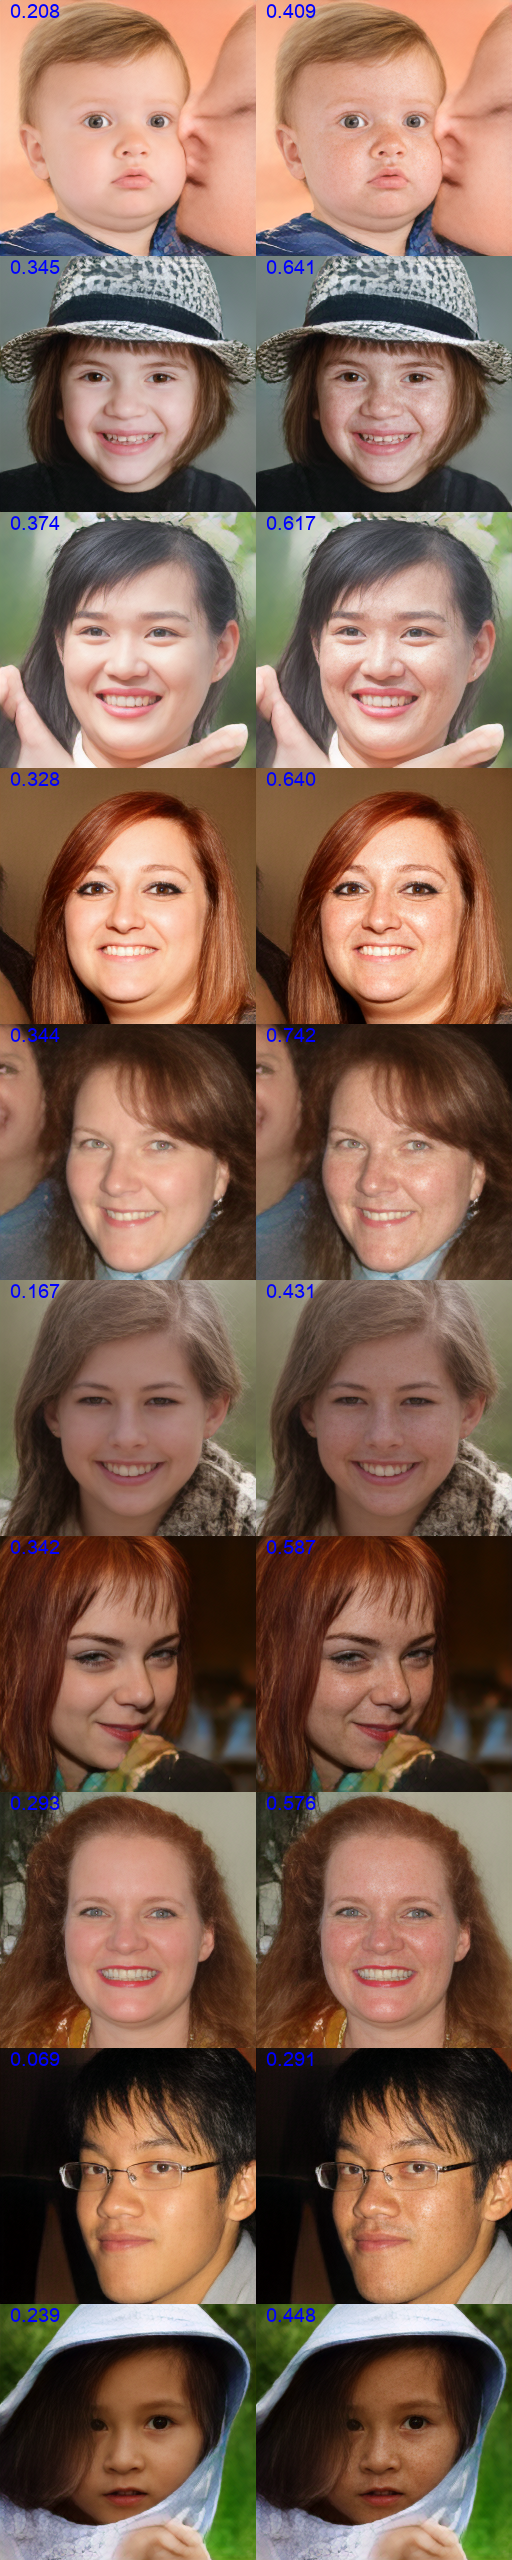

In [9]:
#@title Visualize s-index {form-width: '20%'}

max_images = 10 #@param
sindex =   5300#@param
class_index = 0#@param {type: "integer"} 
shift_sign = "1" #@param [0, 1]
wsign_index = int(shift_sign)

shift_size =  1#@param
effect_threshold =  0.2#@param
split_by_class = True #@param {type:"boolean"}
select_images_by_s_distance = True #@param {type:"boolean"}
draw_results_on_image = True #@param {type:"boolean"}

if split_by_class:
  split_ind = 1 if class_index == 0 else 0
  all_s = style_effect_classes[split_ind]
  all_w = W_classes[split_ind]
  all_s_distances = style_vectors_distances_classes[split_ind]
else:
  all_s = style_change_effect
  all_w = W_values
  all_s_distances = all_style_vectors_distances

font_file = '/tmp/arialuni.ttf'
if not os.path.exists(font_file):
  r = requests.get('https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/ipwn/arialuni.ttf')
  open(font_file, 'wb').write(r.content)

if not select_images_by_s_distance:
  yy = visualize_style(generator, 
                       classifier,
                       all_w,
                       all_s,
                       style_min,
                       style_max,
                       sindex,
                       wsign_index,
                       max_images=max_images,
                       shift_size=shift_size,
                       font_file=font_file,
                       label_size=label_size,
                       class_index=class_index,
                       effect_threshold=effect_threshold,
                       draw_results_on_image=draw_results_on_image)
    
else:
  yy = visualize_style_by_distance_in_s(
    generator,
    classifier,
    all_w,
    all_s_distances,
    style_min,
    style_max,
    sindex,
    wsign_index,
    max_images=max_images,
    shift_size=shift_size,
    font_file=font_file,
    label_size=label_size,
    class_index=class_index,
    effect_threshold=effect_threshold,
    draw_results_on_image=draw_results_on_image)

if yy.size > 0:
  show_image(yy)
else:
  print('no images found')

In [10]:
#@title Show animation {form-width: '20%'}

import matplotlib.animation 
from IPython.display import HTML

ani = make_animation(yy, resolution)

HTML(ani.to_jshtml())

In [11]:
#@title Show the 4 top attributes - as displayed in Fig.4 (b)

draw_probabilities_on_image = True #@param {type: "boolean"}
index_to_naming = {0: "Skin Pigminatation", 1: "Add/Remove Glasses", 2: "Eyebrow Thickness", 3: "Dark/White Hair"}
images_list = [[0, 4], [16, 17], [18, 18], [3, 14]]
max_images = 20
shift_sizes = [(2, 1.5),(1, 1),(1, 1),(1.5, 2)]
effect_threshold = 0.05
font_file = '/tmp/arialuni.ttf'
if not os.path.exists(font_file):
  gfile.Copy('/google_src/head/depot/google3/googledata/third_party/fonts/ascender/arialuni.ttf', font_file)

for i, (direction, sindex) in enumerate(s_indices_and_signs[:4]):
  images_s = np.zeros((resolution * 2, resolution * 2, 3)).astype(np.uint8)
  for d in [direction, 1 - direction]:
    # Take only images from the offsite class
    class_index = 0 if d == direction else 1
    split_ind = 1 if d == direction else 0
    all_s = style_effect_classes[split_ind]
    all_w = W_classes[split_ind]
    all_s_distances = style_vectors_distances_classes[split_ind]
    # Generate images
    yy = visualize_style_by_distance_in_s(
      generator,
      classifier,
      all_w,
      all_s_distances,
      style_min,
      style_max,
      sindex,
      d,
      max_images=max_images,
      shift_size=shift_sizes[i][class_index],
      font_file=font_file,
      label_size=label_size,
      class_index=class_index,
      effect_threshold=effect_threshold,
      draw_results_on_image=draw_probabilities_on_image)
    for n in range(2):
      images_s[n * resolution: (n + 1) * resolution, class_index * resolution: (class_index + 1) * resolution, :] = yy[(images_list[i][class_index]) * resolution: (images_list[i][class_index] + 1) * resolution, n * resolution: (n + 1) * resolution, :]
  print(f'Attribute {i} {index_to_naming[i]}: \n(Original images are on the first row, the probabilities displayed are for the other class - left column for being old, right column for being young)')
  show_image(images_s)
  